[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F6_mlp.ipynb)

# Multilayer Perceptron

In this notebook we are going to solve the digit classification with a neural network.

At first we are loading the MNIST data set from `sklearn` and split it into a training and a testing data set.

In [1]:
from torchvision.datasets import MNIST

In [2]:
data = MNIST("data", download=True)
X = data.data.reshape(-1, data.data.shape[-2]*data.data.shape[-1]).numpy()/255.
y = data.targets.numpy()

In [3]:
from sklearn.model_selection import train_test_split

Splitting into training and test data set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(
    n_components=2./3.,
    whiten=True,
)
Y_train = pca.fit_transform(X_train)
Y_test = pca.transform(X_test)

To far the labels on which we are training on are the digits 0-9.

In [7]:
y_train

array([9, 9, 1, ..., 7, 8, 0])

Here we want to transform the labels into the one-hot configuration. Each label is then a vector of length 10, which contains 1 at the label position and 0 everywhere else.

In [8]:
import numpy as np

In [9]:
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]

In [10]:
y_train[42], y_train_oh[42]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In the next step we are creating tensors from our data and labels and send them to the device we want to use for the computation.

In [11]:
import torch

If a CUDA device is available, we want to use it.

In [12]:
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

CUDA is available.


Sending tensors to device.

In [13]:
Y_train    = torch.Tensor(Y_train).to(device)
Y_test     = torch.Tensor(Y_test).to(device)
y_train_oh = torch.Tensor(y_train_oh).to(device)
y_test_oh  = torch.Tensor(y_test_oh).to(device)

PyTorch has the neat functionality of providing data loaders that organize the batching for us.

In [14]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [15]:
batch_size = 1_000

In [16]:
dataloader = {}
_ = TensorDataset(Y_train, y_train_oh)
dataloader["train"] = DataLoader(_, batch_size=batch_size, shuffle=True)
_ = TensorDataset(Y_test, y_test_oh)
dataloader["test"] = DataLoader(_, batch_size=len(Y_test), shuffle=False)

A data loader is an object that can be iterated through and it is always returning batches with the size of `batch_size` of the data. For every new runt through the data is is re-shuffling in the case for the training set.  
The test data set is only used for evaluation. Here we want to get all the data at once. Shuffling is not needed.

In the next step we design the neural network itself. It is in principle a sequential application of operations. The `Linear` operation is a simple matrix-vector multiplication with the addition of a bias.

$\large y = x \cdot \mathbb{A}^\mathrm{T} + b$

The linear operation has an input dimension and an output dimension. In our first layer the input dimension is the dimension of our data. In this case 64 for the 8x8 digits. The first layer reduces the dimensions to 32, the second layer to 16, and the final layer to 10 to reproduce our one-hot vector.

In between the linear layers we need a non-linear activation function. Otherwise the concatenation of linear transformations lead to a single linear transformation. In this example we are using the `SELU` scaled exponential linear unit as activation function.

$\large \mathrm{SELU} \left(x\right) = \lambda \left(  \max\left(0, x\right) + \min\left(0, \alpha\left(\exp\left(x\right)-1\right) \right) \right)$

With appropriate choices for $\lambda$ and $\alpha$ and the correct initialization this leads to a [self-normalizing neural network](https://arxiv.org/abs/1706.02515).

In between the layers we add dropout layers. A classical dropout layer randomly sets activations to 0 with a probability of `p_drop`. In the case of a self-normalizing neural network this would shift the mean and the variance. `AlphaDropout` is an implementation of a dropout layer that ensures the self-normalizing property of the neural network.

At the output layer we could apply the `Softmax` activation to get a probability representation fo our one-hot vector. However, as seen later, our loss function is doing this internally and we do not want to apply it twice.

$\large \mathrm{Softmax} \left( x_i \right) = \frac{\exp \left( x_i \right)}{\sum\limits_j \exp \left( x_j \right)}$

Therefore, we are adding another function that is returning the probabilities from the model output for later analysis.

In [17]:
class MLP(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, p_drop=0.):
        super().__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Linear(128, 64),
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Linear(64, 32),
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Linear(32, 16),
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Linear(16, output_dim),
        )
        
    def forward(self, x):
        return self.model(x)
    
    @torch.no_grad()
    def probability(self, x):
        self.eval()
        softmax = torch.nn.Softmax(dim=1)
        return softmax(self.model(x))

In [18]:
p_drop = 0.03

In [19]:
net = MLP(Y_train.shape[1], 10, p_drop=p_drop).to(device)

The network now takes a batch of our data and returns a result vector that we can compare to our one-hot labels in our loss function.

As loss function we choose the `CrossEntropyLoss` which is defined as

$\Large \mathcal{L} \left( x, y \right) = - \sum\limits_{c=1}^C \log \frac{\exp\left( x_c\right)}{\sum\limits_{i=1}^C \exp\left( x_i\right)} y_c$

In [20]:
learning_rate = 1.e-3
weight_decay = 1.e-2
max_epochs = 250

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2)

## Training the Model

In [22]:
import copy
from tqdm.auto import tqdm

In [23]:
def fit(net, dataloader, optimizer, scheduler, criterion, max_epochs):

    train_loss = []
    test_loss  = []
    best_loss = np.inf
    best_net = copy.deepcopy(net)

    pbar = tqdm(range(max_epochs), desc="Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs")
    for e in pbar:

        tr_loss = 0.
        te_loss = 0.

        datalen = len(dataloader["train"])
        
        net.train()
        for i, (data, target) in enumerate(dataloader["train"]):
            optimizer.zero_grad()
            model = net(data)
            loss = criterion(model, target)
            loss.backward()
            optimizer.step()
            scheduler.step(e + i/datalen)
            tr_loss += loss.item()

        net.eval()
        for data, target in dataloader["test"]:
            model = net(data)
            loss = criterion(model, target)
            te_loss += loss.item()

        train_loss.append(tr_loss/len(dataloader["train"]))
        test_loss.append(te_loss/len(dataloader["test"]))
        
        if test_loss[-1] < best_loss:
            best_net = copy.deepcopy(net)
            best_loss = test_loss[-1]
        
        pbar.set_description("Train Loss: {:1.3e} | Test Loss: {:1.3e} | Best Loss: {:1.3e} | Epochs".format(train_loss[-1], test_loss[-1], best_loss))
        
    loss = {
        "train": train_loss,
        "test": test_loss
    }
        
    return best_net, loss

In [24]:
net, loss = fit(net, dataloader, optimizer, scheduler, criterion, max_epochs)

Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

## Loss Evaluation

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

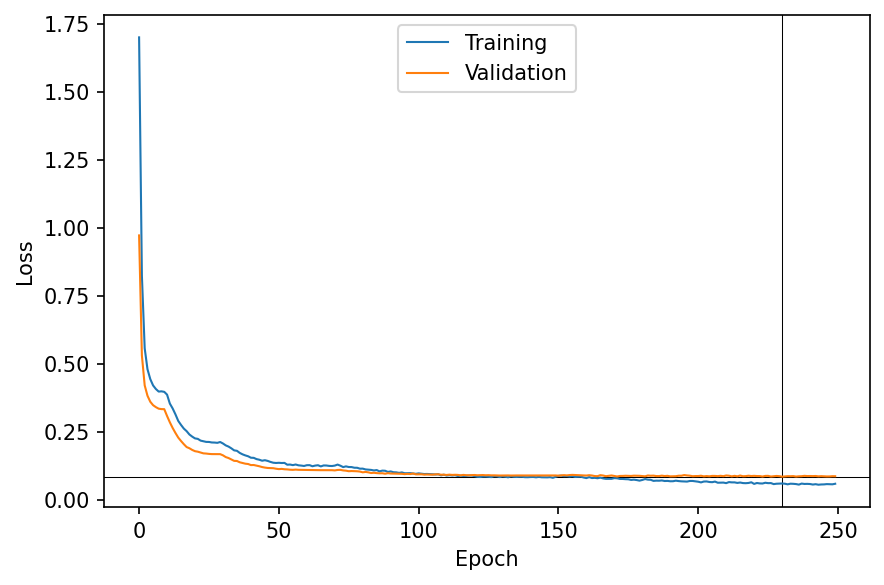

In [26]:
fig, ax = plt.subplots()
ax.axhline(np.min(loss["test"]), lw=0.5, c="black")
ax.axvline(np.argmin(loss["test"]), lw=0.5, c="black")
ax.plot(loss["train"], label="Training", lw=1)
ax.plot(loss["test"], label="Validation", lw=1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()

## Predictions

In [27]:
def plot_prob(X, y, pred, i=None):
    width = 3.
    height = width/1.6
    if i is None:
        i = np.random.randint(0, len(X)-1)
    d = int(np.sqrt(X[0].shape[0]))
    fig = plt.figure(figsize=(3.*width, height))
    ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2)
    ax1.imshow(X[i, :].reshape((d, d)), cmap="Greys", vmax=X.max(), vmin=X.min())
    ax1.axis("off")
    ax1.set_title("Digit: {}".format(y[i]))
    ax2.bar(np.arange(10), pred[i, :]/pred[i, :].sum()*100)
    ax2.set_xlabel("Digit")
    ax2.set_ylabel("Probability")
    ax2.set_ylim(0., 100)
    ax2.grid(axis="y")
    ax2.set_xticks(np.arange(10))
    ax2.set_title("Prediction: {}".format(pred[i].argmax()))
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(["{:3.0f}%".format(p) for p in ax2.get_yticks()])
    fig.tight_layout()

In [28]:
pred_train = net.probability(Y_train).cpu().detach().numpy()
pred_test  = net.probability(Y_test).cpu().detach().numpy()

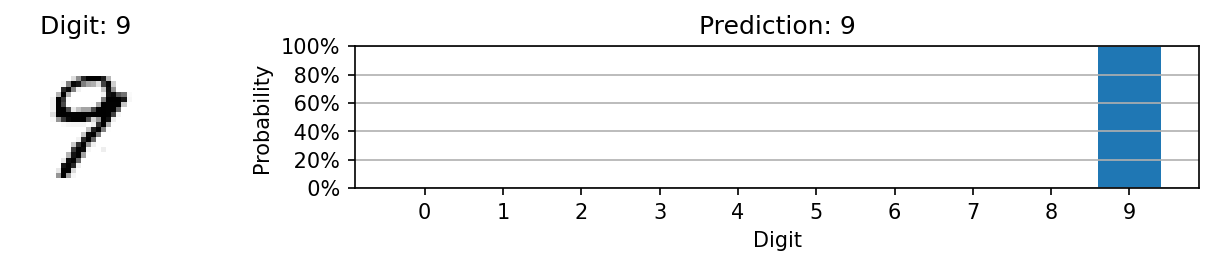

In [29]:
plot_prob(X_test, y_test, pred_test)

### Checking the failures

In [30]:
mask_fail = y_test != pred_test.argmax(1)

In [31]:
msg = "Total number of false identifications: {}".format(mask_fail.sum())
print(msg)

Total number of false identifications: 261


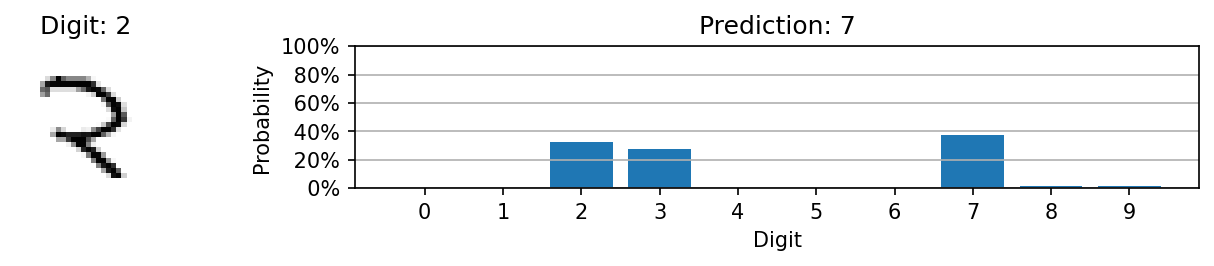

In [32]:
plot_prob(X_test[mask_fail], y_test[mask_fail], pred_test[mask_fail])

## Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
cmat_test = confusion_matrix(y_test, pred_test.argmax(1), normalize="pred")

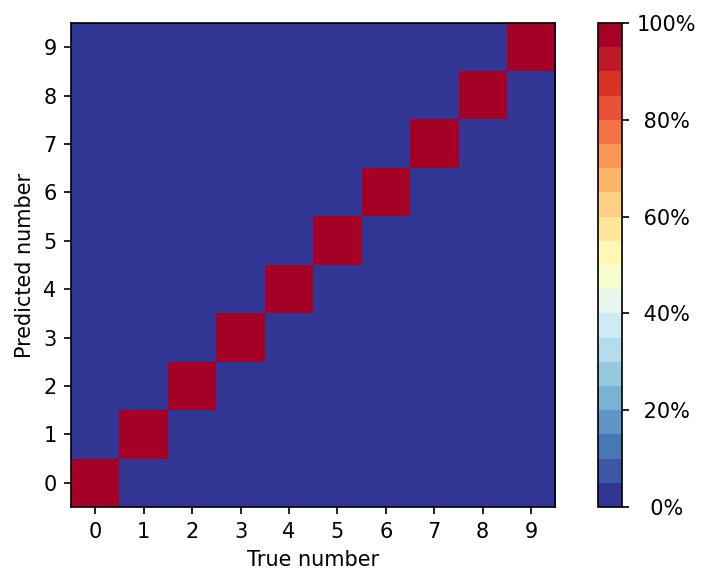

In [35]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

## Accuracy

In [36]:
acc_train = (y_train == pred_train.argmax(1)).sum()/len(y_train)
acc_test = (y_test == pred_test.argmax(1)).sum()/len(y_test)

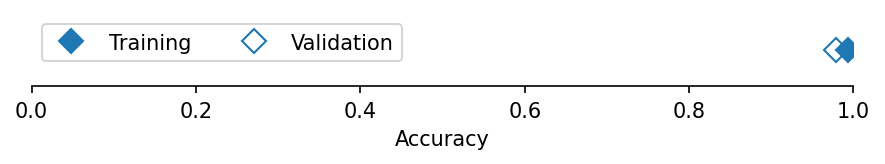

In [37]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(acc_train, 0, "D", markersize=8, fillstyle="full", c="C0", label="Training")
ax.plot(acc_test, 0, "D", markersize=8, fillstyle="none", c="C0", label="Validation")
ax.set_xlim(0., 1.)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.legend(loc="upper left", ncol=2)
fig.tight_layout()